In [1]:
from pymongo import MongoClient
from datetime import datetime
import pandas as pd

In [2]:
from pymongo import MongoClient
from datetime import datetime
import pandas as pd
db_config = {
    'host' : '172.31.98.107:27017,172.31.98.190:27017,172.31.98.6',
    'username' : 'admin',
    'password' : 'y3aJOBqfxsHu',
    'port' : 27017,
    'connectTimeoutMS' : 3000
}
database_name = 'xindong'
collect_name = 'user_watch_duration'

In [3]:
# mongodb session
db_ = MongoClient(**db_config)[database_name]

In [4]:
def query_by_datetime(start_date=None, end_date=None, collect_name=None, db_=None):
    # start_date <= t < end_date
    if start_date is not None and end_date is not None:
        start_date_dt = datetime.strptime(start_date, '%Y-%m-%d')
        end_date_dt = datetime.strptime(end_date, '%Y-%m-%d')
        nosql_query = {
            'createdAt': {
                    '$gte': start_date_dt,
                    '$lt': end_date_dt
                    }
        }
    else:
        nosql_query = {}
    watch_duration_data = list(db_[collect_name].find(nosql_query))
    return pd.DataFrame(watch_duration_data)


In [5]:
def calculateCTR(dat, threshold = 0, user_set=None):
    user2rec_info = dict()
    missing_user_num = 0
    match_user_num = 0
    for record in dat.to_dict('records'):
        userId = record['userId']
        if user_set is not None and userId not in user_set:
            missing_user_num +=1
            continue
        match_user_num +=1
        userId = record['userId']
        videoId = record['videoId']
        totalDuration = record['totalDuration']
        if userId not in user2rec_info:
            user2rec_info[userId] = {'pos' : [], 'neg' : []}
        if totalDuration >= threshold:
            user2rec_info[userId]['pos'].append(videoId)
        else:
            user2rec_info[userId]['neg'].append(videoId)
    unique_CTR = [0, 0]
    overall_CTR = [0, 0]
    user_list = list(user2rec_info.keys())
    for u in user_list:
        pos = user2rec_info[u]['pos']
        neg = user2rec_info[u]['neg']
        # overall
        overall_CTR[0] += len(pos)
        overall_CTR[1] += len(pos+neg)
        # unique
        unique_CTR[0] += len(set(pos))
        unique_CTR[1] += len(set(pos+neg))
    overall_CTR_ = overall_CTR[0] / overall_CTR[1]
    unique_CTR_ = unique_CTR[0] / unique_CTR[1]
    #if user_set is not None:
    #    print('missing_user_num : ', missing_user_num)
    #    print('match_user_num : ', match_user_num)
    #    print('-------')
    return overall_CTR_, unique_CTR_


In [215]:
collect_name = 'user_recommend_medias'
start_date = None
end_date = None
rec_reuslt_dat = query_by_datetime(start_date, end_date, collect_name, db_)

In [8]:
rec_reuslt_dat.head(2)

,_id,userId,mediaIds,updatedAt
0,63adac0378b4fc28304e4a23,91693,"[21208,21373,21156,21483,19473,21448,21450,213...",0001-01-01 00:00:00
1,63adac0378b4fc28304e4a26,91776,"[97364,81988,47743,97347,82399,83305,34376,964...",0001-01-01 00:00:00


In [216]:
# build user2rec_result
user2rec_result = dict()
for record in rec_reuslt_dat.to_dict('records'):
    userId = record['userId']
    mediaIds = eval(record['mediaIds'])
    user2rec_result[userId] = mediaIds

In [217]:
rec_user_set = set(list(user2rec_result.keys()))

In [6]:
collect_name = 'user_watch_duration'
start_date = '2023-01-16'
end_date = '2023-02-10'
backend_dat = query_by_datetime(start_date, end_date, collect_name, db_)

In [7]:
collect_name = 'user_watch_duration'
start_date = '2023-01-08'
end_date = '2023-01-16'
ml_dat = query_by_datetime(start_date, end_date, collect_name, db_)

In [8]:
collect_name = 'user_watch_duration'
start_date = '2022-12-28'
end_date = '2023-02-10'
all_dat = query_by_datetime(start_date, end_date, collect_name, db_)

In [174]:
all_dat.to_csv('duration_data.csv')

In [176]:
all_dat['totalDuration'] = all_dat['totalDuration'].apply(lambda x: x if x < 100 else 100)

Text(0.5, 0, 'duration (second)')

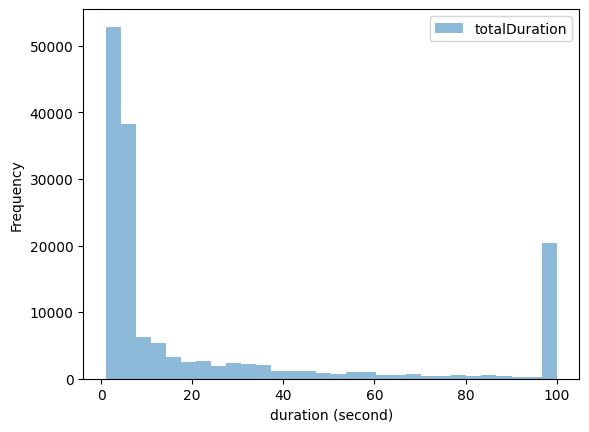

In [130]:
all_dat[['totalDuration']].plot.hist(bins=30, alpha=0.5)
plt.xlabel('duration (second)')

Text(0.5, 0, 'duration (second) [ml]')

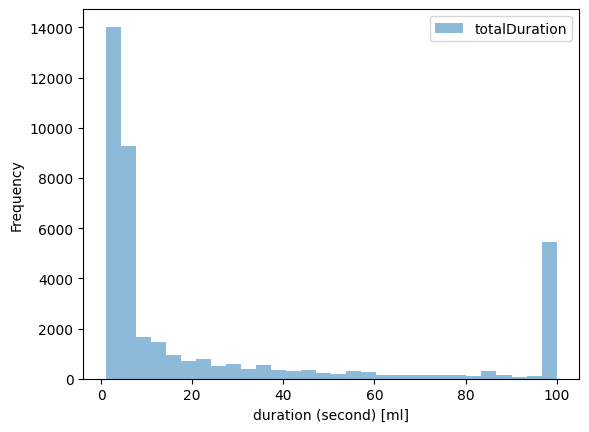

In [168]:
ml_dat['totalDuration'] = ml_dat['totalDuration'].apply(lambda x: x if x < 100 else 100)
ml_dat[['totalDuration']].plot.hist(bins=30, alpha=0.5)
plt.xlabel('duration (second) [ml]')

Text(0.5, 0, 'duration (second) [backend]')

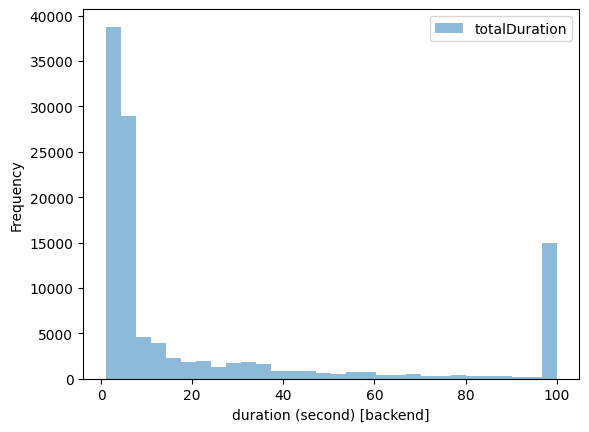

In [169]:
backend_dat['totalDuration'] = backend_dat['totalDuration'].apply(lambda x: x if x < 100 else 100)
backend_dat[['totalDuration']].plot.hist(bins=30, alpha=0.5)
plt.xlabel('duration (second) [backend]')

In [187]:
collect_name = 'user_watch_duration'
all_dat = query_by_datetime(None, None, collect_name, db_)
all_dat[['totalDuration']].describe([i/10 for i in range(10)])

,totalDuration
count,1.575500e+05
mean,4.330598e+02
std,5.905944e+04
min,1.000000e+00
0%,1.000000e+00
10%,2.000000e+00
20%,3.000000e+00
30%,4.000000e+00
40%,5.000000e+00
50%,5.000000e+00


In [14]:
ml_dat.head(2)

,_id,userId,videoId,totalDuration,parts,createdAt
0,63c02bb57ff01641a6e5d089,355391,21049,17.0,"[{""start"":0,""end"":17,""duration"":17}]",2023-01-12 15:48:05.679
1,63c02b997ff01641a6e5d087,355391,30030,7.0,"[{""start"":0,""end"":7,""duration"":7}]",2023-01-12 15:47:37.956


In [ ]:
'''
1. filter user [easy]
2. filter video [difficult]
match_user_num = 24944
missing_user_num = 822
'''

In [ ]:
'''
使用者數量 : 24944 + 822
影片數量 : 3716
Backend推薦 時間 : 2022/12/28~2023/01/07
ML推薦 時間 : 2023/01/08 ~ 2023/01/13
推薦版位: 首頁推薦 
'''

In [9]:
threshold = [i for i in range(25)]
overall_CTR_bk, overall_CTR_ml = [], []
unique_CTR_bk, unique_CTR_ml = [], []
overall_CTR_diff, unique_CTR_diff = [], []
for thr in threshold:
    overall_ctr_bk_, unique_ctr_bk_ = calculateCTR(backend_dat, threshold = thr)
    overall_ctr_ml_, unique_ctr_ml_  = calculateCTR(ml_dat, threshold = thr, user_set=rec_user_set)
    overall_CTR_bk.append(overall_ctr_bk_)
    unique_CTR_bk.append(unique_ctr_bk_)
    overall_CTR_ml.append(overall_ctr_ml_)
    unique_CTR_ml.append(unique_ctr_ml_)
    # diff
    overall_P = '{:.2f}%'.format(float(((overall_ctr_ml_ - overall_ctr_bk_) / overall_ctr_bk_) * 100))
    unique_p = '{:.2f}%'.format(float(((unique_ctr_bk_ - unique_ctr_ml_) / unique_ctr_bk_) * 100))
    overall_CTR_diff.append(round(100*(overall_ctr_ml_ - overall_ctr_bk_) / overall_ctr_bk_,2))
    unique_CTR_diff.append(round(100*(unique_ctr_ml_ - unique_ctr_bk_) / unique_ctr_bk_,2))


NameError: name 'rec_user_set' is not defined

In [ ]:
print('overall_CTR_bk : ', overall_CTR_bk[:15])
print('overall_CTR_ml : ', overall_CTR_ml[:15])
print('overall_CTR_diff : ', overall_CTR_diff[:15])

overall_CTR_bk :  [1.0, 1.0, 0.9203480589022758, 0.8254350736278447, 0.7429718875502008, 0.6516733601070951, 0.43734939759036146, 0.4179384203480589, 0.40147255689424366, 0.38701472556894245, 0.372289156626506, 0.3562248995983936, 0.3461847389558233, 0.3388219544846051, 0.33025435073627846]
overall_CTR_ml :  [1.0, 1.0, 0.9222446139820546, 0.8155078930953409, 0.7294995441677463, 0.6472098267837436, 0.4459958735185452, 0.4280264862530589, 0.41262415431121346, 0.3986133103018089, 0.3873854421572861, 0.3715272779617101, 0.36205076531836283, 0.35279017321625644, 0.3439134398541337]
overall_CTR_diff :  [0.0, 0.0, 0.21, -1.2, -1.81, -0.68, 1.98, 2.41, 2.78, 3.0, 4.05, 4.3, 4.58, 4.12, 4.14]


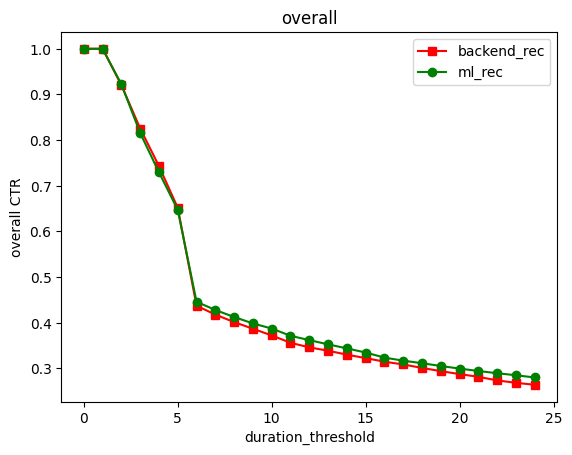

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

plt.plot(threshold,overall_CTR_bk,'s-',color = 'r', label="backend_rec")
plt.plot(threshold,overall_CTR_ml,'o-',color = 'g', label="ml_rec")

plt.title("overall")
plt.xlabel("duration_threshold")
plt.ylabel("overall CTR")
plt.legend()
plt.show()

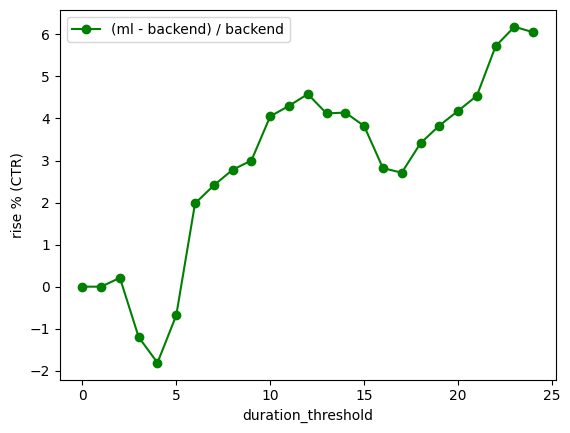

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

plt.plot(threshold,overall_CTR_diff,'o-',color = 'g', label="(ml - backend) / backend")

#plt.title("")
plt.xlabel("duration_threshold")
plt.ylabel("rise % (CTR)")
plt.legend()
plt.show()

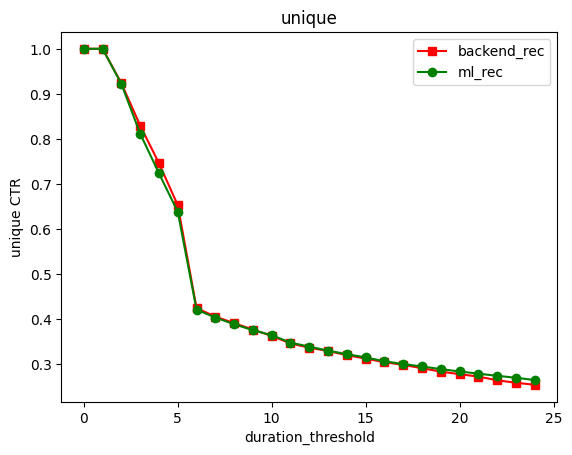

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties


#plt.figure(figsize=(15,10),dpi=100,linewidth = 2)
# 把資料放進來並指定對應的X軸、Y軸的資料，用方形做標記(s-)，並指定線條顏色為紅色，使用label標記線條含意
plt.plot(threshold,unique_CTR_bk,'s-',color = 'r', label="backend_rec")
# 把資料放進來並指定對應的X軸、Y軸的資料 用圓形做標記(o-)，並指定線條顏色為綠色、使用label標記線條含意
plt.plot(threshold,unique_CTR_ml,'o-',color = 'g', label="ml_rec")
 
# 設定圖片標題，以及指定字型設定，x代表與圖案最左側的距離，y代表與圖片的距離
plt.title("unique")
# 设置刻度字体大小
# 標示x軸(labelpad代表與圖片的距離)
plt.xlabel("duration_threshold")
# 標示y軸(labelpad代表與圖片的距離)
plt.ylabel("unique CTR")
# 顯示出線條標記位置
plt.legend()
# 畫出圖片
plt.show()

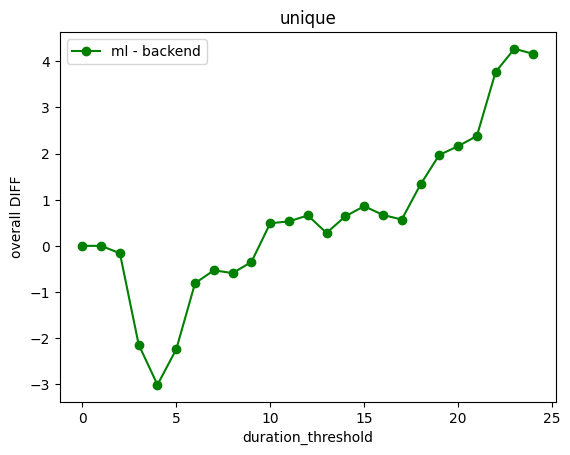

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

plt.plot(threshold,unique_CTR_diff,'o-',color = 'g', label="ml - backend")

plt.title("unique")
plt.xlabel("duration_threshold")
plt.ylabel("overall DIFF")
plt.legend()
plt.show()

In [113]:
collect_name = 'user_vip_record'
user_data = query_by_datetime(start_date=None, end_date=None, collect_name=collect_name, db_=db_)

In [115]:
user_data.head(1)

,_id,userID,vipType,vipDuration,vipUsedTime,cardID,buyAt,createdAt,updatedAt,startAt,endAt,useRecord
0,61487de87fa65e4643db6ace,12261,4,30,0,12071,2021-09-20 12:26:15.933,2021-09-20 12:26:15.933,0001-01-01 00:00:00,2021-09-20 12:26:15.933,2021-10-20 12:26:15.933,[]


In [116]:
'''
使用者數量 : 24944 + 822
影片數量 : 3716
Backend推薦 時間 : 2022/12/28~2023/01/07
ML推薦 時間 : 2023/01/08 ~ 2023/01/13
推薦版位: 首頁推薦 
'''

{2, 3, 4, 5, 7, 8}

In [125]:
user_data[(user_data['buyAt']>= '2022-12-28') & (user_data['buyAt']< '2023-01-08')].shape[0] / 11

1.9090909090909092

In [126]:
user_data[(user_data['buyAt']>= '2023-01-08') & (user_data['buyAt']< '2023-01-16')].shape[0] / 8

0.625

In [131]:
all_dat.head(1)

,_id,userId,videoId,totalDuration,parts,createdAt
0,63c40f548bbca5bbefbd3959,145845,26419,5.0,"[{""start"":0,""end"":5,""duration"":5}]",2023-01-15 14:36:04.013


In [ ]:
from datetime import timedelta
start_date = '2022-12-28'
end_date = '2023-02-10'
date_list = [start_date]
while date_list[-1] != end_date:
    date_dt = datetime.strptime(date_list[-1], '%Y-%m-%d')
    date_dt += timedelta(days=1)
    date_list.append(date_dt.strftime('%Y-%m-%d'))

In [ ]:
active_user_num = []
avg_duration = []
avg_watch_num = []
date_list_up = []
watch_num = []
for i in range(1, len(date_list)):
    st_date = date_list[i-1]
    ed_date = date_list[i]
    dat_ = all_dat[(all_dat['createdAt']>= st_date) & (all_dat['createdAt']< ed_date)]
    u_n = len(set(dat_['userId']))
    active_user_num.append(u_n)
    avg_watch_num.append(dat_.shape[0] / u_n)
    watch_num.append(dat_.shape[0])
    try:
        avg_duration.append(sum(dat_['totalDuration']) / len(dat_['totalDuration']))
        date_list_up.append(st_date)
    except:
        pass

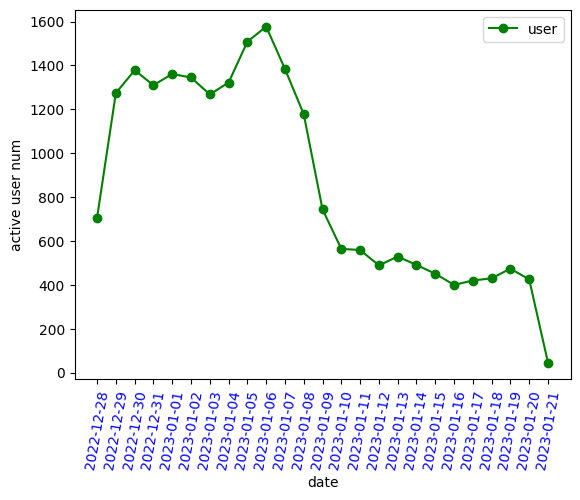

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
date_list_ = [date_[4:] for date_ in date_list]
plt.plot(date_list[:-1],active_user_num,'o-',color = 'g', label="user")

plt.xlabel("date")
plt.ylabel("active user num")
plt.legend()
plt.xticks(date_list[:-1],color='blue',rotation=80)
plt.show()

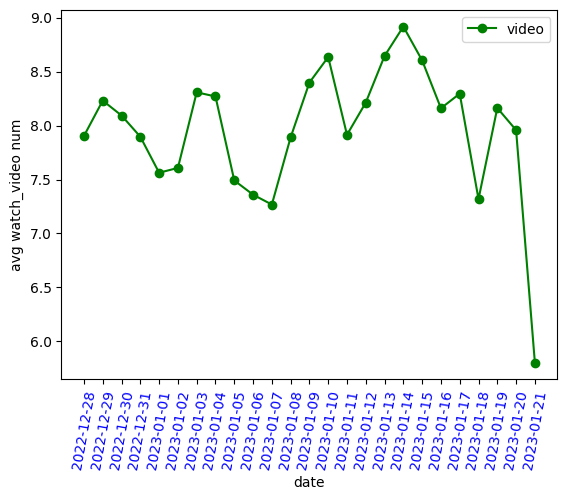

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
date_list_ = [date_[4:] for date_ in date_list]
plt.plot(date_list[:-1],avg_watch_num,'o-',color = 'g', label="video")

plt.xlabel("date")
plt.ylabel("avg watch_video num")
plt.legend()
plt.xticks(date_list[:-1],color='blue',rotation=80)
plt.show()

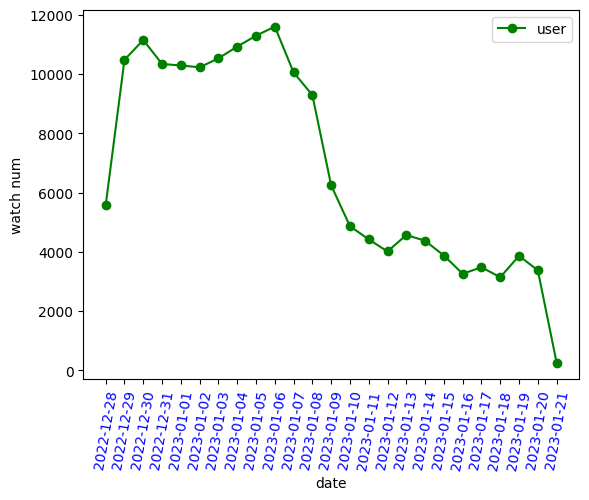

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
date_list_ = [date_[4:] for date_ in date_list]
plt.plot(date_list[:-1],watch_num,'o-',color = 'g', label="user")

plt.xlabel("date")
plt.ylabel("watch num")
plt.legend()
plt.xticks(date_list[:-1],color='blue',rotation=80)
plt.show()

In [10]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

plt.plot(date_list_up,avg_duration,'o-',color = 'g', label="video")

plt.xlabel("date")
plt.ylabel("avg duration")
plt.xticks(date_list_up,color='blue',rotation=80)
plt.legend()
plt.show()

NameError: name 'date_list_up' is not defined

In [32]:
collect_name = 'media'
media_data = list(db_[collect_name].find())
dat = pd.DataFrame(media_data)
used_media = set(dat[dat['contentType'].isin([1,2])]['_id'])

In [76]:
len(used_media)

5011

<AxesSubplot: >

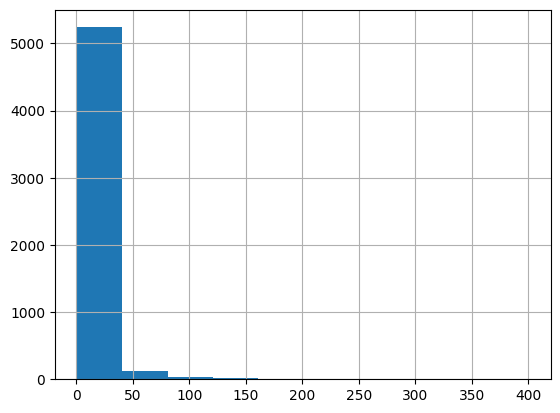

In [78]:
# query watch-duration data
collect_name = 'user_watch_duration'
all_watch_duration_data = list(db_[collect_name].find())
dat = pd.DataFrame(all_watch_duration_data)
dat = dat[dat['videoId'].isin(used_media)]

In [84]:
dat_ = dat.groupby(by=["userId"]).count()
dat_[['_id']].describe([i/10 for i in range(10)])

,_id
count,5422.000000
mean,9.366654
std,19.718790
min,1.000000
0%,1.000000
10%,1.000000
20%,2.000000
30%,2.000000
40%,3.000000
50%,4.000000


In [85]:
dat.shape

(50786, 6)

In [61]:
start_date = '2022-12-31'
start_date_dt = datetime.strptime(start_date, '%Y-%m-%d')
now_date_dt = datetime.now()
nosql_query = {
    'createdAt': {
            '$gte': start_date_dt,
            '$lt': now_date_dt
            }
}
watch_duration_data = list(db_[collect_name].find(nosql_query))
dat = pd.DataFrame(watch_duration_data)
used_user_set = set(dat[dat['videoId'].isin(used_media)]['userId'])

In [62]:
len(all_user_set & used_user_set) / len(all_user_set)

0.5111731843575419

In [63]:
len(all_user_set)

5370

In [64]:
len(used_user_set)

2771

In [39]:
min(dat['createdAt'])

Timestamp('2022-12-28 09:42:31.395000')

In [46]:
now_date_dt

datetime.datetime(2023, 1, 2, 14, 49, 53, 202626)

In [ ]:
'2023-01-01'
0.3016759776536313
-
'2022-12-31'
0.5111731843575419
-
'2022-12-30'
0.7219739292364991
-
'2022-12-29'
0.9070763500931098

In [72]:
start_date = '2022-12-28'
start_date_dt = datetime.strptime(start_date, '%Y-%m-%d')
end_date = '2022-12-30'
end_date_dt = datetime.strptime(end_date, '%Y-%m-%d')
nosql_query = {
    'createdAt': {
            '$gte': start_date_dt,
            '$lt': end_date_dt
            }
}
watch_duration_data = list(db_[collect_name].find(nosql_query))
dat = pd.DataFrame(watch_duration_data)
used_user_setC = set(dat[dat['videoId'].isin(used_media)]['userId'])

In [ ]:
used_user_setA | ('2022-12-31', '2023-01-01')
used_user_setB | ('2022-12-30', '2022-12-31')
used_user_setC | ('2022-12-29', '2022-12-30')

In [75]:
len(used_user_setB & used_user_setC) / len(used_user_setB)

0.12481857764876633

In [70]:
len(used_user_setA)

1310

In [71]:
len(used_user_setB)

1378

In [74]:
len(used_user_setC)

1274

In [26]:
# query watch-duration data
collect_name = 'user_watch_duration'
all_watch_duration_data = list(db_[collect_name].find())
dat = pd.DataFrame(all_watch_duration_data)

In [40]:
collect_name = 'user_watch_duration'
all_watch_duration_data = list(db_[collect_name].find())
dat = pd.DataFrame(all_watch_duration_data)

In [41]:
min(dat['createdAt'])

Timestamp('2022-12-28 09:42:31.395000')

In [10]:
# given window and calculate cover rate

In [18]:
datetime.now()

datetime.datetime(2023, 1, 2, 14, 32, 13, 461156)

In [17]:
import pytz
zone_tz = pytz.timezone('Asia/Taipei')
date_dt = datetime.strptime(start_date, '%Y-%m-%d')
zone_tz.localize(date_dt).astimezone(pytz.utc)

datetime.datetime(2022, 12, 24, 16, 0, tzinfo=<UTC>)

In [15]:
all_watch_duration_data[:10]

[{'_id': ObjectId('63ac0f877ff01641a6e293dc'),
  'userId': 340660,
  'videoId': 96300,
  'totalDuration': 2.0,
  'parts': '[{"start":0,"end":2,"duration":2}]',
  'createdAt': datetime.datetime(2022, 12, 28, 9, 42, 31, 395000)},
 {'_id': ObjectId('63ac0f948bbca5bbefb9b468'),
  'userId': 340660,
  'videoId': 32968,
  'totalDuration': 2.0,
  'parts': '[{"start":0,"end":2,"duration":2}]',
  'createdAt': datetime.datetime(2022, 12, 28, 9, 42, 44, 516000)},
 {'_id': ObjectId('63ac0f9b8bbca5bbefb9b469'),
  'userId': 340660,
  'videoId': 92909,
  'totalDuration': 1.0,
  'parts': '[{"start":0,"end":1,"duration":1}]',
  'createdAt': datetime.datetime(2022, 12, 28, 9, 42, 51, 607000)},
 {'_id': ObjectId('63ac0fe87ff01641a6e293e8'),
  'userId': 340660,
  'videoId': 92909,
  'totalDuration': 2.0,
  'parts': '[{"start":0,"end":2,"duration":2}]',
  'createdAt': datetime.datetime(2022, 12, 28, 9, 44, 8, 837000)},
 {'_id': ObjectId('63ac0ff17ff01641a6e293ed'),
  'userId': 340660,
  'videoId': 92893,
  

In [ ]:
now_date = datetime.now().strftime('%Y-%m-%d')